In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import pandas as pd
import matplotlib.pyplot as plt

import random
import multiprocessing

In [2]:
# use gpu for training if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Model specification

In [3]:
class Multiple_layer_fc_network(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Multiple_layer_fc_network, self).__init__()
        self.fc1 = nn.Linear(input_size, 100)
        self.fc2 = nn.Linear(100, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Dimensionality checking with random inputs
Recommend to do so to ensure the data flow in your model is as you expected

In [4]:
x = torch.randn(64, 784)
model = Multiple_layer_fc_network(input_size=784, num_classes=10)
out = model(x)
print(out.shape)

torch.Size([64, 10])


### Global Variables Specification

In [5]:
input_size = 784 # 28*28=784
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 50
num_workers = 16 #multiprocessing.cpu_count() 

early_stopping_criteria= 5

val_proportion = 0.2

data_dir = "/mnt/addtional_data_ssd/pytorch_tutorials/data" # change this path to your preferred directory to store fashion minst data

### Set up Dataset and DataLoader

In [6]:
train_dataset = datasets.FashionMNIST(root=data_dir, train=True, transform=transforms.ToTensor(), download=True)
test_dataset  = datasets.FashionMNIST(root=data_dir, train=False, transform=transforms.ToTensor(), download=True)


val_size = int(val_proportion*len(train_dataset))
train_size = len(train_dataset) - val_size
test_size = len(test_dataset)

print(f"number samples in train: {train_size}")
print(f"number samples in val: {val_size}")
print(f"number samples in test: {test_size}")

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

number samples in train: 48000
number samples in val: 12000
number samples in test: 10000


In [7]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [8]:
# check the dimensions of the data
image, target = train_dataset[0]
print("input image has shape:")
print(image.shape)

input image has shape:
torch.Size([1, 28, 28])


### Show Images
Just to get a better sense of how fashion-mnist dataset looks like

In [9]:
def show_single_image(dataset, image_index):
    image, label = dataset[image_index]
    image = torch.squeeze(image).numpy()
    plt.imshow(image, cmap="binary")
    plt.show()

def show_imgs(n_rows, n_cols, dataset, class_names):
    assert n_rows * n_cols < len(dataset)
    selected_indicies = random.sample(range(len(dataset)), n_rows * n_cols)
    plt.figure(figsize = (n_cols * 1.4, n_rows * 1.6))
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col 
            plt.subplot(n_rows, n_cols, index+1)
            image_index = selected_indicies[index]
            image, label = dataset[image_index]
            image = torch.squeeze(image).numpy()
            plt.imshow(image, cmap="binary", interpolation = 'nearest')
            plt.axis('off')
            plt.title(class_names[label])
    plt.show()

show the first image


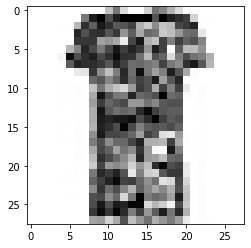

show 20 randomly selected images


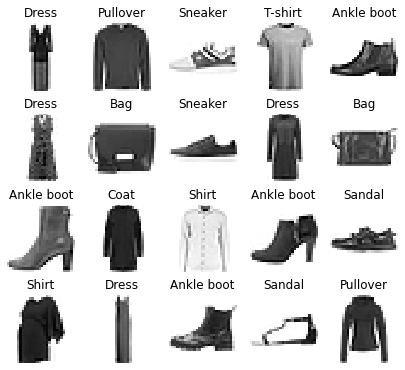

In [10]:
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print("show the first image")
show_single_image(train_dataset, image_index=0)
print("show 20 randomly selected images")
show_imgs(4, 5, train_dataset, class_names)

### Model Initialization, Loss, Optimizer

In [11]:
clf = Multiple_layer_fc_network(input_size=input_size, num_classes=num_classes)
clf.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf.parameters(), lr=learning_rate)

### Initialize a dictionary to record training progress

In [12]:
train_state = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

### Train the model

In [13]:
best_val_loss = float('inf')
early_stopping_step = 0

for epoch in range(num_epochs):
    running_train_loss = 0.0 # running loss for every 200 steps during training
    train_loss = 0.0 # accumulated training loss for the entire epoch
    num_train_samples = 0 
    correct = 0
    for batch_idx, (images, targets) in enumerate(train_loader):
        # transfer data to gpu if available
        images, targets = images.to(device), targets.to(device)
        #print(images.shape, targets.shape)
        
        # reshape the images to proper shape
        batch_size = images.shape[0]
        images = images.reshape(batch_size, -1)
        
        # forward pass
        preds = clf(images)
        loss = criterion(preds, targets)
        
        # back prop
        optimizer.zero_grad()
        loss.backward()
        
        # update model params
        optimizer.step()
        
        # evaluate performance for each batch
        running_train_loss += loss.item()
        train_loss += loss.item() * batch_size
        num_train_samples += batch_size
        _, pred_labels = torch.max(preds, dim=1)
        correct += (pred_labels==targets).sum().item()

        # print training stat every 200 steps
        if ((batch_idx+1) % 200==0):
            print(f"[epoch {epoch} step {batch_idx}] running training loss: {running_train_loss/200:.3f}")
            running_train_loss = 0.0
    
    epoch_train_loss= train_loss/num_train_samples
    epoch_train_acc= correct/num_train_samples
            
    # evaluate on the validation set every epoch
    with torch.no_grad():
        val_loss = 0.0
        num_val_samples = 0 
        correct = 0
        for images, targets in val_loader:
            images, targets = images.to(device), targets.to(device)
            batch_size = images.shape[0]
            images = images.reshape(batch_size, -1)
            preds = clf(images)
            loss = criterion(preds, targets)
            val_loss += loss.item() * images.shape[0]
            num_val_samples += batch_size
            # calculate accuracy
            preds = clf(images)
            _, pred_labels = torch.max(preds, dim=1)
            correct += (pred_labels==targets).sum().item()
    epoch_val_loss= val_loss/num_val_samples
    epoch_val_acc= correct/num_val_samples
    print(f"[epoch {epoch}] val loss: {epoch_val_loss:.3f}, accuracy: {100*epoch_val_acc:.3f}%")
    
    # update train_state dict
    train_state['train_loss'].append(epoch_train_loss)
    train_state['train_acc'].append(epoch_train_acc)
    train_state['val_loss'].append(epoch_val_loss)
    train_state['val_acc'].append(epoch_val_acc)
    
    # early stopping
    if (epoch_val_loss < best_val_loss):
        best_val_loss = epoch_val_loss
        early_stopping_step = 0
        print(f"current best validation loss: {best_val_loss:.3f}")
    else:
        early_stopping_step += 1
        print(f"validation loss stops decreasing for {early_stopping_step} epoch")
        if (early_stopping_step==early_stopping_criteria):
            print("early stopping criteria reached")
            break
    print("--------------------------------------------")
            

[epoch 0 step 199] running training loss: 0.815
[epoch 0 step 399] running training loss: 0.528
[epoch 0 step 599] running training loss: 0.497
[epoch 0] val loss: 0.439, accuracy: 84.783%
current best validation loss: 0.439
--------------------------------------------
[epoch 1 step 199] running training loss: 0.445
[epoch 1 step 399] running training loss: 0.430
[epoch 1 step 599] running training loss: 0.403
[epoch 1] val loss: 0.394, accuracy: 86.150%
current best validation loss: 0.394
--------------------------------------------
[epoch 2 step 199] running training loss: 0.392
[epoch 2 step 399] running training loss: 0.385
[epoch 2 step 599] running training loss: 0.374
[epoch 2] val loss: 0.372, accuracy: 87.058%
current best validation loss: 0.372
--------------------------------------------
[epoch 3 step 199] running training loss: 0.361
[epoch 3 step 399] running training loss: 0.373
[epoch 3 step 599] running training loss: 0.355
[epoch 3] val loss: 0.372, accuracy: 86.617%
v

### Test the network on the test data

In [14]:
with torch.no_grad():
    test_loss = 0.0
    num_test_samples = 0 
    correct = 0
    for images, targets in test_loader:
        images, targets = images.to(device), targets.to(device)
        batch_size = images.shape[0]
        images = images.reshape(batch_size, -1)
        preds = clf(images)
        loss = criterion(preds, targets)
        test_loss += loss.item() * images.shape[0]
        num_test_samples += batch_size
        # calculate accuracy
        preds = clf(images)
        _, pred_labels = torch.max(preds, dim=1)
        correct += (pred_labels==targets).sum().item()
print(f"testing loss: {test_loss/num_test_samples:.3f}, testing accuracy: {100*correct/num_test_samples:.3f}%")


testing loss: 0.359, testing accuracy: 88.060%


### Plot learning curve

In [15]:
def plot_learning_curves(train_hist_df, title):
    num_epoch = train_hist_df.shape[0]
    train_hist_df.plot(figsize=(8, 5), title=title, xticks=range(1, num_epoch+1, 3))
    plt.grid(True)
    ymin, ymax = 0.95 * train_hist_df.values.min(), min(1.1 * train_hist_df.values.max(), 1.0)
    plt.gca().set_ylim(ymin, ymax)
    plt.show()

    train_loss  train_acc  val_loss   val_acc
0     0.585323   0.800792  0.439246  0.847833
1     0.426876   0.850167  0.394168  0.861500
2     0.383432   0.863938  0.371589  0.870583
3     0.361409   0.869854  0.372434  0.866167
4     0.342587   0.876646  0.347549  0.873000
5     0.324037   0.882292  0.345530  0.876583
6     0.311295   0.887188  0.328275  0.881833
7     0.297433   0.891208  0.323885  0.882833
8     0.287349   0.895042  0.326986  0.881500
9     0.275033   0.899417  0.323109  0.879167
10    0.267435   0.901479  0.335344  0.882667
11    0.259678   0.903625  0.304631  0.892167
12    0.251360   0.907375  0.304638  0.888750
13    0.244248   0.909354  0.309126  0.885167
14    0.237213   0.913146  0.303944  0.889333
15    0.232368   0.913875  0.308383  0.891000
16    0.225514   0.916583  0.294183  0.895167
17    0.222109   0.918917  0.305469  0.891833
18    0.212628   0.921125  0.327361  0.884750
19    0.209707   0.922958  0.304610  0.892750
20    0.206021   0.923958  0.31258

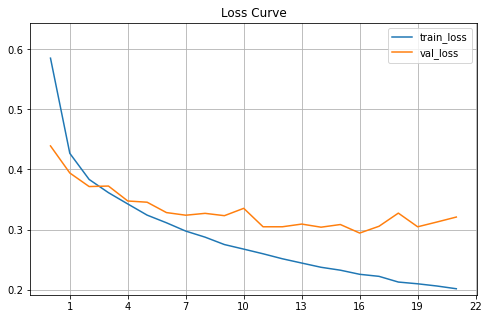

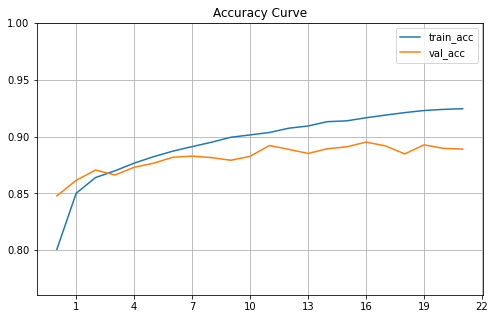

In [16]:
train_state_df = pd.DataFrame(train_state)
print(train_state_df)
plot_learning_curves(train_state_df[['train_loss', 'val_loss']], "Loss Curve")
plot_learning_curves(train_state_df[['train_acc', 'val_acc']], "Accuracy Curve")